# HTML Retrieval Experiment

Many LLM applications require user-specific data that is not part of the model's training set. The primary way of accomplishing this is through Retrieval Augmented Generation (RAG). In this process, external data is retrieved and then passed to the LLM when doing the generation step. Here, we carry out a pilot study to see how feasible it is to locate appropriate HTML documents given an NL query.


## Experiment Setup
Library LangChain - [Retrieval](https://python.langchain.com/docs/modules/data_connection/)

- Document loader: **TextLoader**, with raw html source code
- Document transformer: **SentenceTransformersTokenTextSplitter**, it is a specialized text splitter for use with the sentence-transformer models . The default behaviour is to split the text into chunks that fit the token window of the sentence transformer model that you would like to use.
- Text Embedding Model: **all-MiniLM-L6-v2** of [Sentence-transformer](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), it maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search. By default, input text longer than 256 word pieces is truncated.
- Vector search & stores: **FAISS**, on-cpu with local caching 

In [1]:
import os, glob
import matplotlib.pyplot as plt
from PIL import Image

from langchain.document_loaders import TextLoader
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings, CacheBackedEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

In [2]:
# Param Settings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

name_space = "auto-sBERT"
model_name = "sentence-transformers/all-MiniLM-L6-v2"

# init splitter, fit the model input seq size
text_splitter = SentenceTransformersTokenTextSplitter(model_name=model_name)

# init embedding models
hfe = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cpu'},
)

# init Cache-Backed Embedder
lfs = LocalFileStore(os.path.join("./Embeddings", name_space))

cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings = hfe, 
    document_embedding_cache = lfs,
    namespace=name_space
)

## Dataset Load

The Web-based Structural Reading Comprehension (**WebSRC**) dataset consists of 440K question-answer pairs, which are collected from 6.5K web pages with corresponding HTML source code, screenshots, and metadata. Each question in WebSRC requires a certain structural understanding of a webpage to answer, and the answer is either a text span on the web page or yes/no. After adding the additional yes/no tokens to the text input, WebSRC can be modeled as a typical extractive reading comprehension task.

Here we leverage all HTML files from **auto**(automobile, vehicle) domain from [WebSRC Official](https://x-lance.github.io/WebSRC/), [Hugging Face Page](https://huggingface.co/datasets/TravelLeraLone/WebSRC_v1.0) for experiment. The **auto** category, which has an equally-counted sample size, covers the three main categories of webpages (KV, Table, and Comparison) based on the distribution of the dataset.

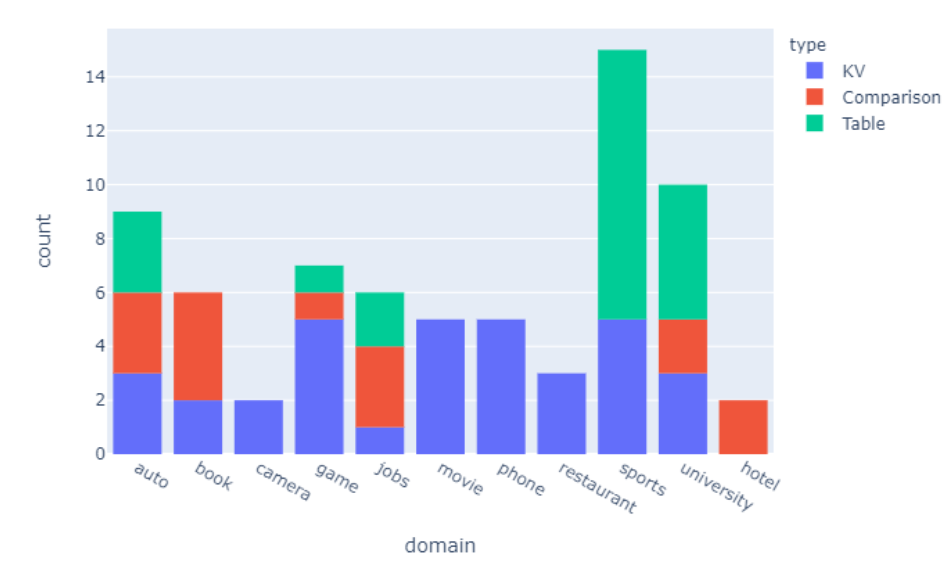

In [3]:
%%time

# test on batch HTMLs
html_dir = f'../WebSRC/auto/*/processed_data/*.html'
docs = []

for fp in glob.glob(html_dir):
    loader = TextLoader(fp)
    data = loader.load_and_split(text_splitter)
    docs.extend(data)
    
# total Documents
len(docs)

CPU times: user 9.94 s, sys: 140 ms, total: 10.1 s
Wall time: 9.39 s


5611

In [4]:
docs[:3]

[Document(page_content='< html tid = " 0 " > < body tid = " 1 " > < div class = " tab - pane active " id = " trim - specs " tid = " 2 " > < div class = " specs show - more - container collapsed row " tid = " 3 " > < div class = " exterior - interior col - sm - 6 " tid = " 4 " > < table tid = " 5 " > < thead tid = " 6 " > < tr tid = " 7 " > < td tid = " 8 " > interior < / td > < / tr > < / thead > < tbody tid = " 9 " > < tr tid = " 10 " > < td class = " type " tid = " 11 " > front head room < / td > < td class = " spec " tid = " 12 " > 38 " < / td > < / tr > < tr tid = " 13 " > < td class = " type " tid = " 14 " > rear head room < / td > < td class = " spec " tid = " 15 " > 38 " < / td >', metadata={'source': '../WebSRC/auto/03/processed_data/0300542.html'}),
 Document(page_content='< tr tid = " 13 " > < td class = " type " tid = " 14 " > rear head room < / td > < td class = " spec " tid = " 15 " > 38 " < / td > < / tr > < tr tid = " 16 " > < td class = " type " tid = " 17 " > front sho

In [5]:
%%time
# construct VectorDB
db = FAISS.from_documents(docs, cached_embedder)

CPU times: user 1.17 s, sys: 422 ms, total: 1.59 s
Wall time: 2.59 s


> CPU times: user 20min 16s, sys: 1min 11s, total: 21min 28s, Wall time: 3min 41s

## NL Query Generation
*Prompt: give me some Natural Language Query (NLQ) samples in the field of automobile, vehicles, or tech specs about a certain car model*

*ChatGPT Response: Here are some samples of NLQs in the field of movies:*

- "What is the horsepower of the 2019 Ford Mustang?"
- "Tell me the fuel efficiency of the Toyota Prius 2018 model."
- "How much does the 2020 BMW 5 Series weigh?"
- "What type of engine is in the Honda Civic 2017?"
- "Can you give me the safety features of the Mercedes-Benz S-Class from 2019?"


**Below test query is manually generated based on the output and all vehicle models can be found in original dataset**

In [6]:
# display_images_with_scores, generated by ChatGPT
def display_images_with_scores(html_paths_scores, columns=3):
    """
    Given a list of tuples containing relative paths to HTML files and associated scores, this function finds
    the PNG images with the same base name in the same directory, loads them, and displays them in a grid layout
    in a Jupyter notebook. Each image is displayed with its filename and score in the title.

    :param html_paths_scores: List of tuples (html_path, score).
    :param columns: Number of columns in the grid.
    """
    # Determine the number of rows needed based on the number of images and desired columns
    rows = len(html_paths_scores) // columns + (len(html_paths_scores) % columns > 0)
    
    # Set up the figure and axes for the grid
    fig, axs = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))
    axs = axs.flatten()  # Flatten the axes array for easy iteration
    
    for idx, (html_path, score) in enumerate(html_paths_scores):
        # Extract the directory and the base file name from the HTML path
        base_dir, html_filename = os.path.split(html_path)
        base_filename = os.path.splitext(html_filename)[0]
        png_filename = f"{base_filename}.png"

        # Construct the path for the PNG file
        png_path = os.path.join(base_dir, png_filename)

        # Load and display the image with the filename and score in the title
        try:
            image = Image.open(png_path)
            axs[idx].imshow(image)
            title = f"{png_filename} - Score: {score}"
            axs[idx].set_title(title, fontsize=10)  # Show the image file name and score as the title
            axs[idx].axis('off')  # Turn off axis numbers
        except FileNotFoundError:
            axs[idx].set_title("File Not Found", fontsize=10)
            axs[idx].axis('off')
        except Exception as e:
            axs[idx].set_title(f"Error: {e}", fontsize=10)
            axs[idx].axis('off')

    # Hide any remaining empty subplots
    for ax in axs[len(html_paths_scores):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# display_images_with_scores([("a/bb/ccc.html", 0.95), ("a/bb/ddd.html", 0.82)], columns=2)


# def retrieval helper function, default top_k = 3
def html_retrieval_by_query(query, top_k=3):
    embedding_vector = hfe.embed_query(query)
    docs = db.similarity_search_with_score_by_vector(embedding_vector, k=top_k)
    display_images_with_scores([(doc[0].metadata['source'], doc[1]) for doc in docs])
    
    return

## Similarity search by vector

calculated by cosine similarity and sorted by the query relevance, scroll down to check the evaluation

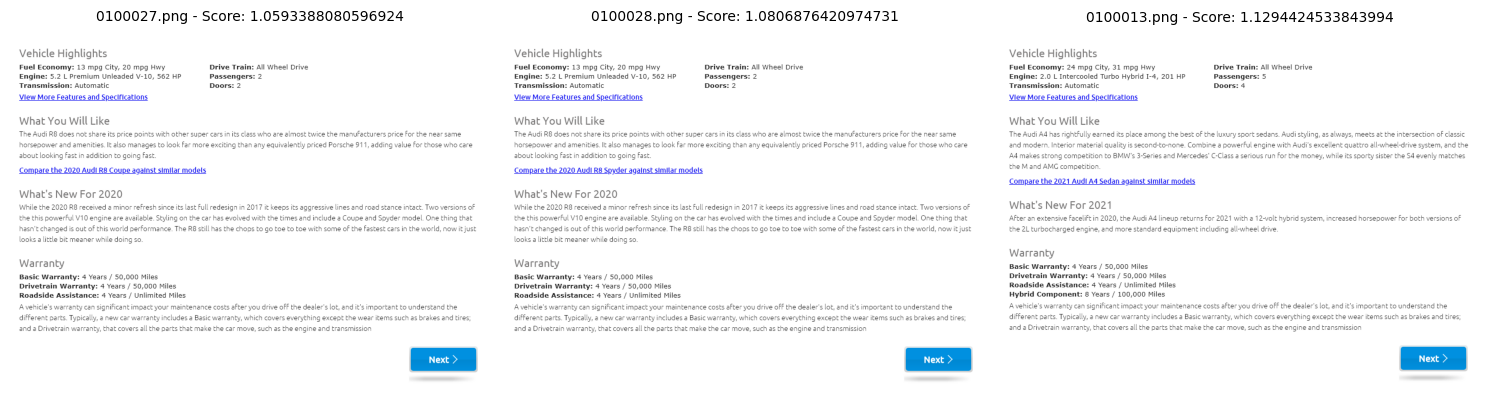

In [7]:
# 0900041
html_retrieval_by_query("How is the engine performance of the '2018 Maserati Ghibli'?") 

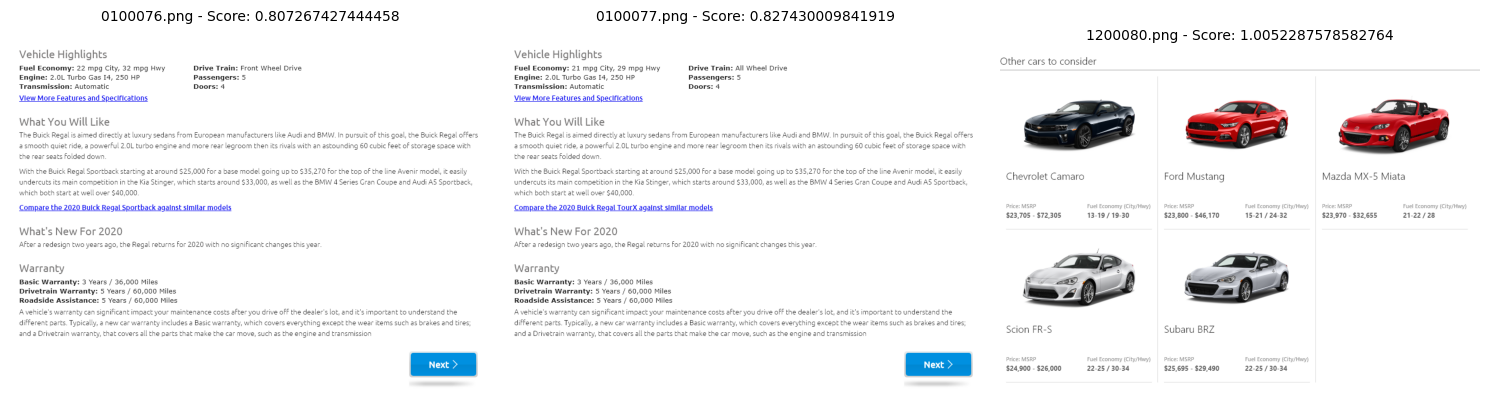

In [8]:
# 1200047
html_retrieval_by_query("The price MSRP of 'Kia Sportage'") 

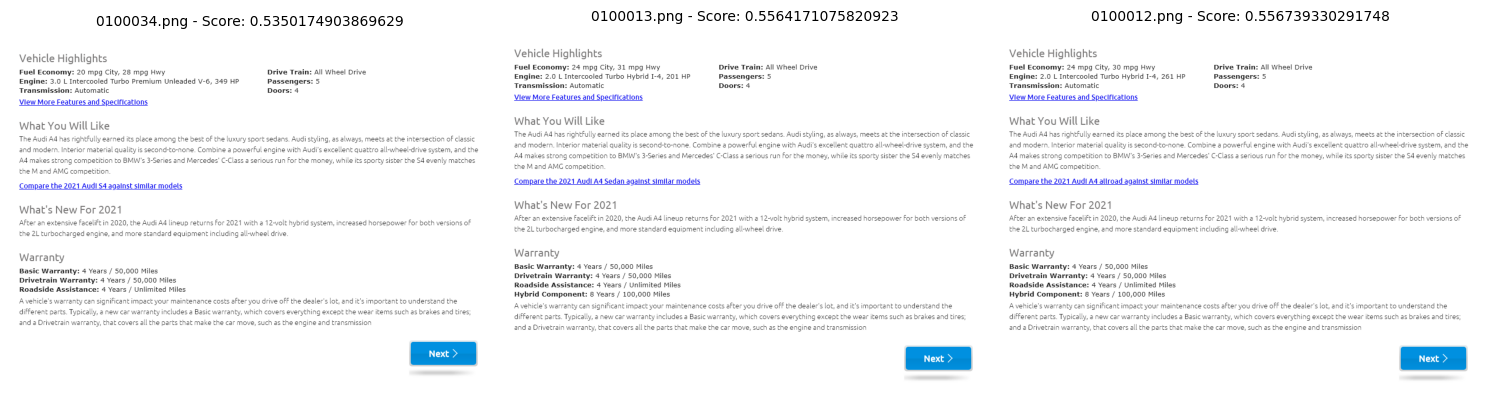

In [9]:
# 0100011
html_retrieval_by_query("Anything new in 2020 for 'Audi A4'") 

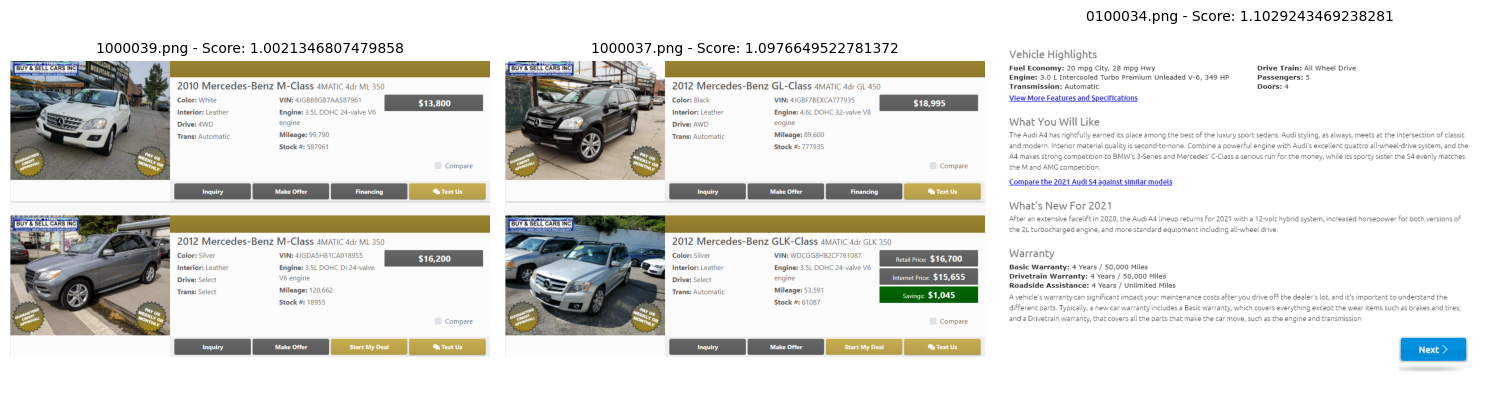

In [10]:
# 1000039
html_retrieval_by_query("The engine of '2012 Mercedes-Benz M-Class'")

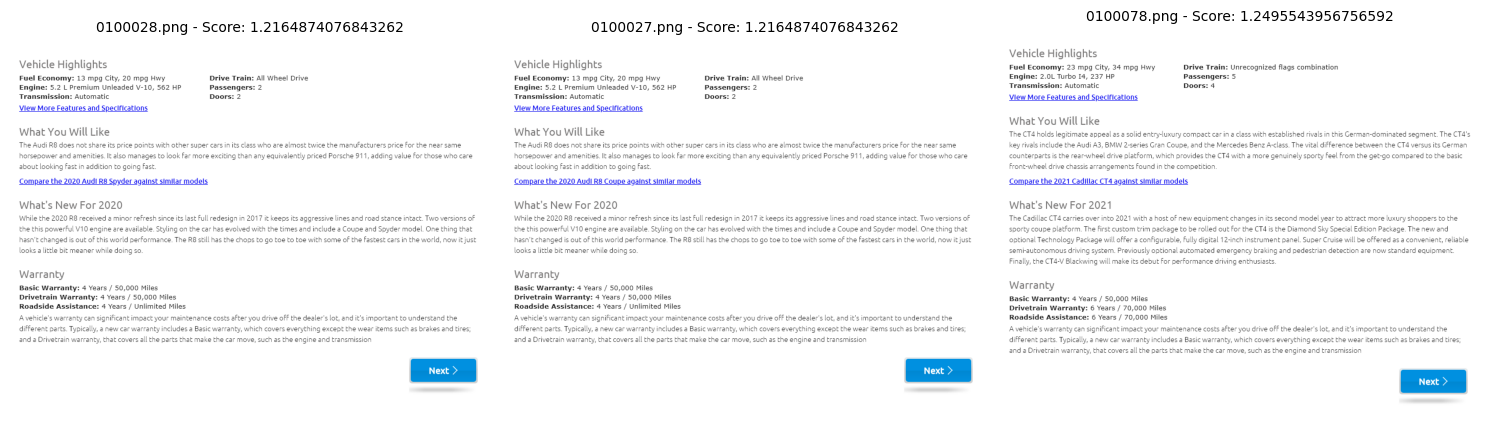

In [11]:
# 0900072
html_retrieval_by_query("Any information about 'Alfa Romeo Stelvio RWD'")

> More complex NL query

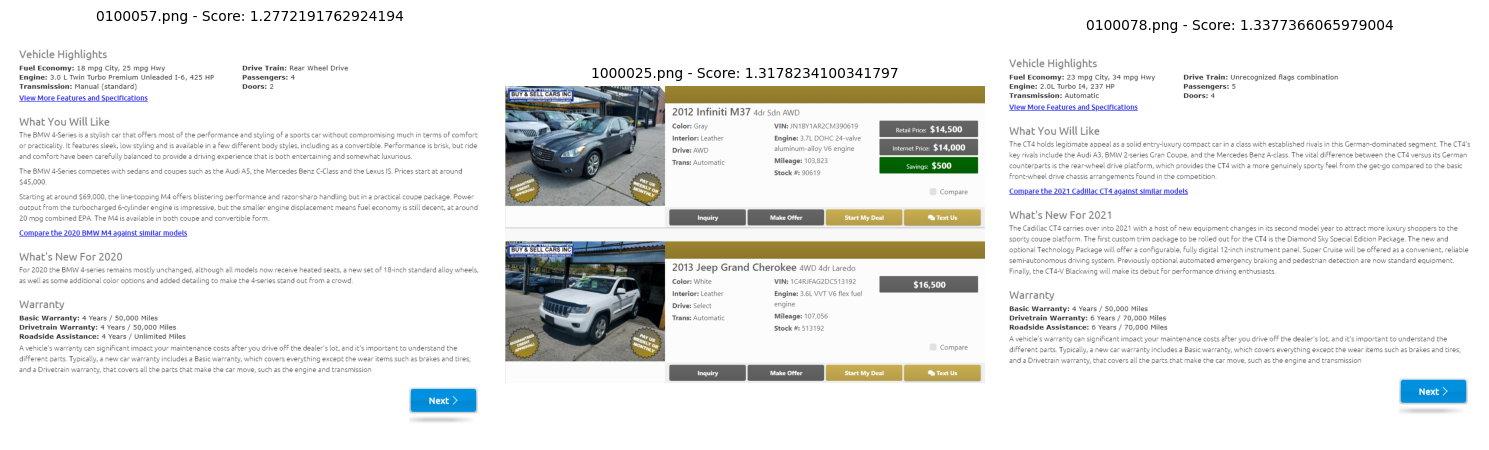

In [12]:
# 1000025
html_retrieval_by_query("For vehicle '2012 Infiniti M37, 4dr Sdn AWD', how much money I can save via online?")

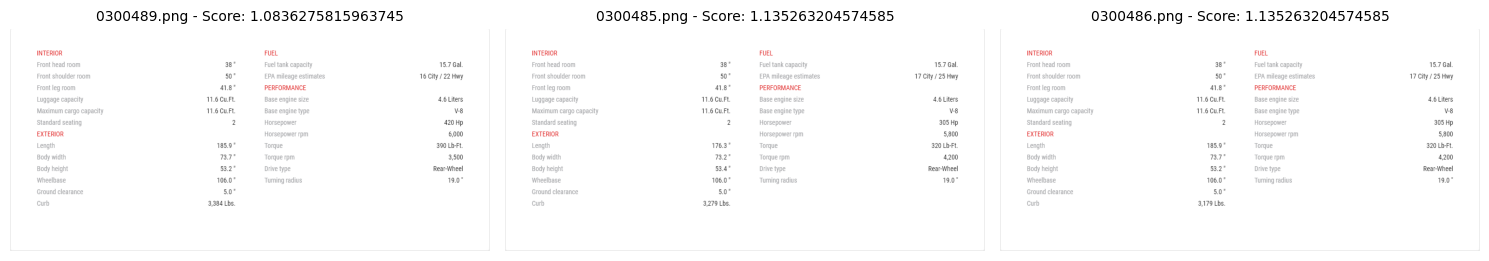

In [13]:
# 1100062
html_retrieval_by_query("What is the fuel consumption with the '5.7L V8 OHV 16-valve engine' and the 'Sport Utility' body type?")

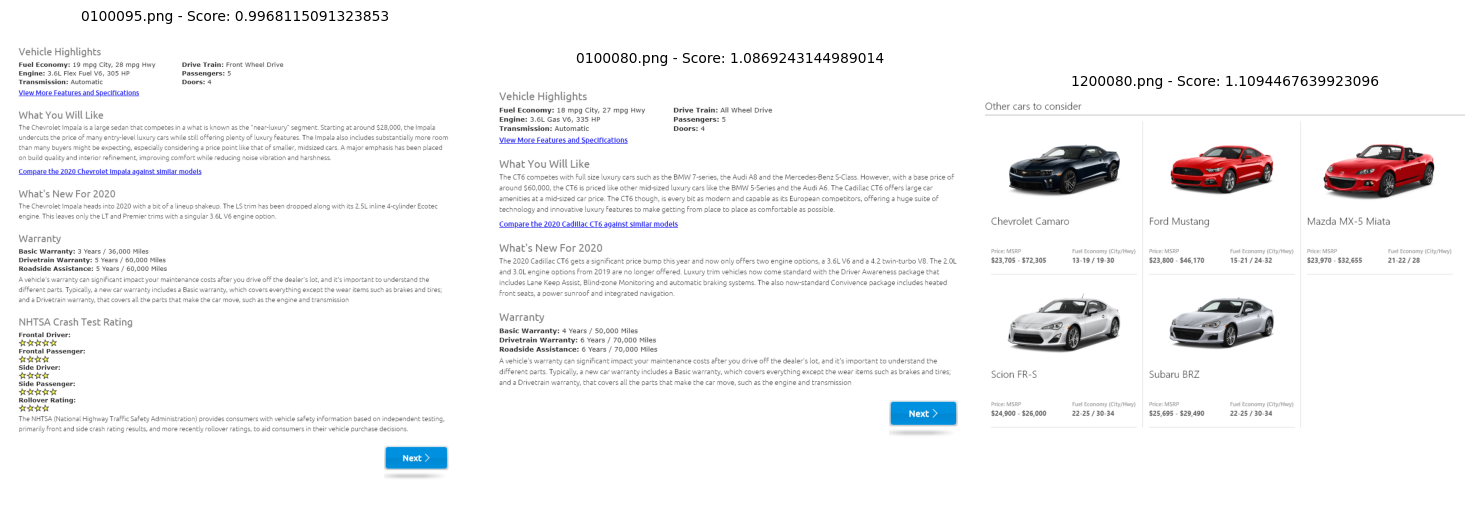

In [14]:
# 1200116
html_retrieval_by_query("A Nissan car with the price MSRP greater than or equal to 24,000")

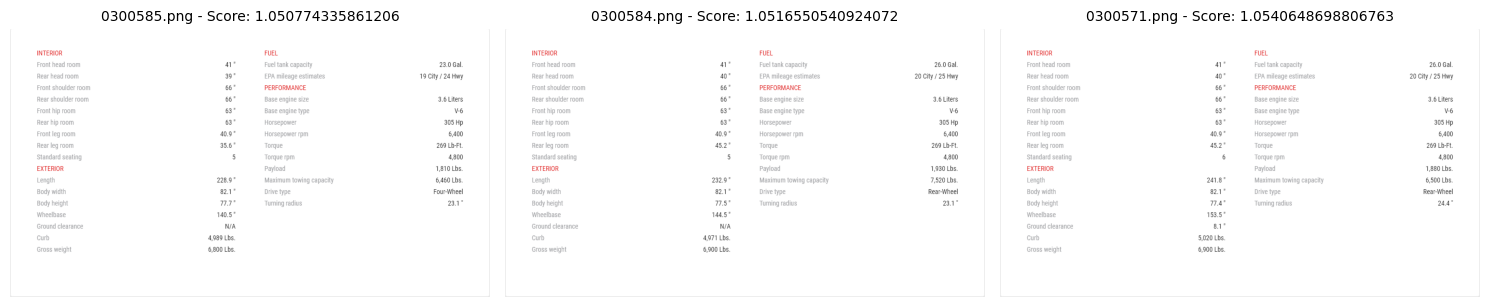

In [15]:
# 0300293
html_retrieval_by_query("Look for a car with a gross weight of 4,409 lbs. and a vehicle length of 171.4 \"") 

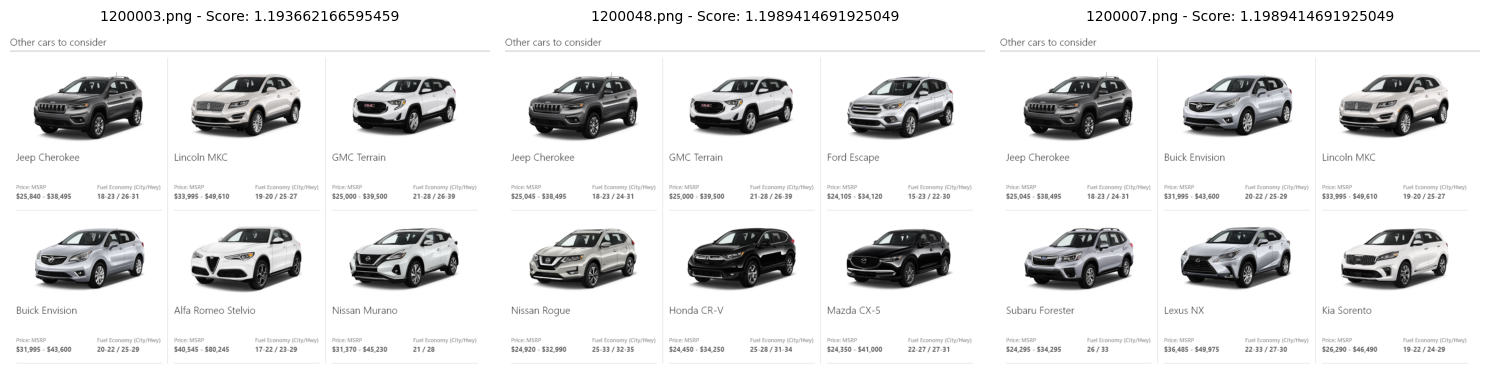

In [16]:
# 1200003
html_retrieval_by_query("For 'Jeep Cherokee' and 'Lincoln MKC', which one has higher fuel consumption?")

## Document-level Top-N Result
| Query |   Top-1   |   Top-2   |   Top-3   |
|:-------------:|:---------:|:---------:|:---------:|
| How is the engine performance of the '2018 Maserati Ghibli'? |     ❌     |     ❌     |     ❌    |
| The price MSRP of 'Kia Sportage' |     ❌     |     ❌     |    ❌    |
| Anything new in 2020 for 'Audi A4' |     ❌     |     ❌      |     ❌     |
| The engine of '2012 Mercedes-Benz M-Class' |     ✔️     |     -     |     -     |
| Any information about 'Alfa Romeo Stelvio RWD' |     ❌     |     ❌     |     ❌     |


| (More complex) Query |   Top-1   |   Top-2   |   Top-3   |
|:-------------:|:---------:|:---------:|:---------:|
| For vehicle '2012 Infiniti M37, 4dr Sdn AWD', how much money I can save via online? |  ❌      |    ✔️     |     -     |
| What is the fuel consumption with the '5.7L V8 OHV 16-valve engine' and the 'Sport Utility' body type? |     ❌     |     ❌     |     ❌    |
| A Nissan car with price MSRP greater than or equal to 24,000  |     ❌     |     ❌     |     ❌    |
| Look for a car with a gross weight of 4,409 lbs. and a vehicle length of 171.4 \" |     ❌     |     ❌     |     ❌    |
| For 'Jeep Cherokee' and 'Lincoln MKC', which one has higher fuel consumption? |  ✔️     |     -     |     -     |


## Failure Analysis
- **Encoder not Fit**: The existing transformer encoder inferred the representation learned by treating the input HTML source code as plain text. As a result, the HTML embeddings might not perform optimally for the retrieval task due to the ignorance of structural features on HTML documents.

- **Dataset Limitation**: The HTML code is cropped from the source webpage for certain downstream operations, such as attribute extraction and question-answering. Therefore, leads to less context awareness at the document level in the vector embeddings. Meanwhile, less context might not support generating numerous and diversified features to distinguish those page embeddings. Consequently, the retrieved HTML might not help to reply to the query.

- **Fuzzy Query**: The effectiveness of a query in retrieving the desired HTML file significantly depends on its specificity, yet there is a concerning lack of control over ensuring that each query is adequately and accurately described, which is problematic.